# **Autonomous Driving : Car Detection with YOLO**

<img src="nb_images/yolo_car_detection.PNG" class="left"/>

---

# **Introduction**

The goal of this project is to implement car object detection using the YOLO (You Only Look Once) model. 
<br/>Object detection ideas were gathered from YOLO papers: [Redmon et al., 2016](https://arxiv.org/abs/1506.02640) and [Redmon and Farhadi, 2016](https://arxiv.org/abs/1612.08242). 


## Notebook Contents

- [Dataset](#0)
- [YOLO Model](#1)
- [YOLO Bounding Box Filtering](#2)
- [YOLO Bounding Box Evaluation](#3)
- [YOLO Pre-trained Model](#4)
- [Object Detection](#5)
- [References](#6)

<a name='0'></a>
# **Dataset**
---

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import cv2
import glob
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline

* Dataset used for this Car object detection model was provided by <a href="https://www.drive.ai/">drive.ai</a>.

* Road video collected from camera mounted on the hood of the Silicon Valley car.

<video width="400" height="200" src="nb_images/road_video_compressed2.mp4" type="video/mp4" controls></video>

<a name='1'></a>
# **YOLO Model**
---

**"You Only Look Once" (YOLO)** is a powerful algorithm with high accuracy for detecting objects in real time because it requires only one forward propagation pass through the network to make predictions. 

### Inputs and outputs

- The **input** is a batch of images, and each image has the shape **(608, 608, 3)**
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$.

**YOLO_v2** detects 80 class objects and so the bounding box item $c$ is 80 dimensional vector where one component is 1. So overall bounding box size is 85. 

<img src="nb_images/box_label.png" style="width:500px;height:250;" class="left">
<caption><u><b>Figure 1</u></b>: YOLO Bounding Box<br></caption>.

### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  
* The dimension of the encoding tensor of the second to last dimension based on the anchor boxes is $(m, n_H,n_W,anchors,classes)$.


### Encoding

* YOLO model is a Deep CNN model which converts image batch (m, 608, 608, 3) into (m, 19, 19, 5, 85) encoding.
* Grid cell on which the center of an object falls, is resposible for detecting the object.
* Each of 19x19 grid cell encodes information of 5 Anchor boxes  

<img src="nb_images/architecture.png" style="width:700px;height:400;" class="left">
<caption><u><b> Figure 2 </u></b>: Encoding architecture for YOLO<br></caption>


* Last 2 dimensions of the (19, 19, 5, 85) encoding are flattened into (19, 19, 425)

<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption> <u><b> Figure 3 </u></b>: Flattening last 2 dimensions of Encoding<br></caption>

### Bounding Box Class Scores

* Each bounding box class scores are calculated by element-wise product, $score_{c,i} = p_{c} \times c_{i}$
* Class score with highest proabability is the detected object class type for the Bounding Box

<img src="nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><u><b>Figure 4</u></b>: Bounding Box Class Scores</caption>


### Visualizing Bounding Box

* Calculate maximum class scores for 5 anchor boxes in each of 19x19 grid cells which represent the object class type
* Color each grid cell according to highest probability class type

<img src="nb_images/proba_map.png" style="width:300px;height:300;">
<caption><u><b>Figure 5</u></b>: 19x19 grid cells colored with highest probability class type</caption>


* Another way to visualize is drawing bounding boxe rectangles in the image

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><u><b>Figure 6</u></b>: Bounding Box rectangles for object class types</caption>

<a name='2'></a>
# **YOLO Bounding Box Filtering**
---

Bounding boxes generated from YOLO model are filtered in 2 steps
- Bounding Box Class Score Filtering 
- Bounding Box Non-max Suppression

## Bounding Box Class Score Filtering 


* Filter bounding boxes based on class scores with specific threshold
* Flatten bounding box dimension from (19,19,5,85) to (19,19,425) for convenience

- `box_confidence`: tensor of shape $(19, 19, 5, 1)$ containing $p_c$ of 19 x 19 grid cells
- `boxes`: tensor of shape $(19, 19, 5, 4)$ containing $(b_x, b_y, b_h, b_w)$ of each 5 anchor boxes in 19 x 19 grid cells
- `box_class_probs`: tensor of shape $(19, 19, 5, 80)$ containing object "class probabilities" $(c_1, c_2, ... c_{80})$ 

Bounding Box Class Score Filtering is implemented in **bounding_box_class_score_filtering** function below 

In [2]:
def bounding_box_class_score_filtering(boxes, box_confidence, box_class_probs, score_threshold = 0.6):
    
    # compute box scores by elementwise products Pc * Ci
    box_scores = box_confidence * box_class_probs

    # find box classes with max class scores in each 19 x 19 x 5 boxes and get max class scores
    box_classes = tf.math.argmax(box_scores, axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1)
    
    # create filtering mask using box class scores and score_threshold
    filtering_mask = box_class_scores >= score_threshold
    
    # apply filtering mask to drop bounding boxes with scores < score_threshold
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    return scores, boxes, classes

## Bounding Box Non-max Suppression

* Non-max Suppression is a bounding box filtering technique to drop unnecessary overlapped boxes generated after class score filtering step

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><u> <b>Figure 7</b> </u>: Bounding Box Non-max Suppression</caption>


* **"Intersection over Union (IoU)"** technique is used for dopping overlapped boxes in Non-max Suppression

<img src="nb_images/iou.png" style="width:500px;height:400;">
<caption><u> <b>Figure 8</b> </u>: "Intersection over Union". </caption>

Key Steps for Non-max Suppression-

* Select the box with highest class score
* Compute IoU of the box with all other boxes, and remove boxes that overlap significantly (IoU >= `iou_threshold`)
* Repeat steps until all lower score boxes are removed 

Non-max Suppression removes all boxes which have large overlap with selected boxes

Bounding Box Non-max Suppression is implemented in **bounding_box_non_max_suppression** function below<br/>
**tf.image.non_max_suppression** is a TensorFlow built-in function for computing Non-max Suppression operation

* `max_boxes`: maximum number of boxes to predict
* `iou_threshold`: IoU threshold for filtering overlapped boxes

In [3]:
def bounding_box_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):

    # max box tensor for filtering NMS
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')

    # bounding box index values to keep after NMS filtering
    keep_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
    
    # select only bounding boxes of keep_indices
    scores = tf.gather(scores,keep_indices)
    boxes = tf.gather(boxes,keep_indices)
    classes = tf.gather(classes,keep_indices)
    
    return scores, boxes, classes

<a name='3'></a>
# YOLO Bounding Box Evaluation
---



Class scores and Non-max Suppressions filtering are performed after YOLO bounding box outputs

* YOLO bounding boxes are converted from box coordinates $(x,y,w,h)$ to box corners $(x1, y1, x2, y2)$

* **box_coordinates_to_corners** function converts bounding box coordinates into corners

In [4]:
def box_coordinates_to_corners(box_xy, box_wh):

    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


* Bounding box shapes are rescaled to plot over the orginial image as YOLO network is trained on 608 x 608 image 

* **scale_boxes** function rescale the bounding box shapes into original image shapes 

YOLO Bounding Box evaluation is implemented in **bounding_box_evaluation** function below

* `score_threshold`: class score filtering threshold
* `iou_threshold`: non-max suppression filtering threshold
* `max_boxes`: maximum number of boxes to predict
* `yolo_outputs`: output of YOLO encoding model
* `image_shape`: shape of original image

In [5]:
def bounding_box_evaluation(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
    # Retrieve outputs of the YOLO model
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # converts bounding box coordinates into corners
    boxes = box_coordinates_to_corners(box_xy, box_wh)
    
    # filter boxes based on class score_threshold 
    scores, boxes, classes = bounding_box_class_score_filtering(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Re-scale bounding boxes into original image
    boxes = scale_boxes(boxes, image_shape)
    
    # filter max number of boxes after non-max suppression based on iou_threshold
    scores, boxes, classes = bounding_box_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

<a name='4'></a>
# YOLO Pre-trained Model
---

## Load YOLO Model

YOLO is a Deep CNN model which requires long time along with very large labeled dataset. So we use a pre-trained YOLO model **YOLO_v2** developed based on paper [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016) by **Joseph Redmond**. YOLO_v2 Model **yolo.h5** is loaded from [Official YOLO website](https://pjreddie.com/darknet/yolo/) in model_data folder. **Allan Zelener** provided functions in [**YAD2K**](https://github.com/allanzelener/YAD2K) for converting YOLO_v2 model into Keras model. 
<br/>
YOLO_v2 model was trained on [MS-COCO dataset](https://cocodataset.org/#home) with over 300K labeled images, 5 anchors per image and 80 object categories. 

In [6]:
yolo_model = load_model("model_data/", compile=False)

yolo_layers = len(yolo_model.layers)
print('Input Shape : ',yolo_model.layers[0].output_shape)
print('Output Shape : ',yolo_model.layers[yolo_layers-1].output_shape)

Input Shape :  [(None, 608, 608, 3)]
Output Shape :  (None, 19, 19, 425)


COCO dataset 80 object classes are loaded from **"model_data/coco_classes.txt"** and 5 anchors are loaded from **"model_data/yolo_anchors.txt"**. <br/> YOLO model requires image size 608x608.

In [7]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")

model_image_size = (608, 608) 

## YOLO Model Prediction

* In order to extract bounding boxes of object from YOLO model, input image needs to be preprocessed as implemented <br/>in `preprocess_input_image` function to scales (608 x 608), reshapes and normalizes the image.  

In [8]:
import imghdr
import colorsys
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from functools import reduce

def preprocess_input_image(image, model_image_size):
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)
    return image, image_data

* In order to format the encoding of `yolo_model` output, `yolo_head` API is used provided by **YAD2K** in `yad2k/models/keras_yolo.py`.
* After formatting YOLO output `bounding_box_evaluation` is used to filter the bounding boxes.
* `draw_boxes` API used to draw boxes of detected object, provided by **YAD2K** in `yad2k/utils/utils.py`.
* **`yolo_model_prediction`** generates bounding box image from YOLO model from given input image

In [9]:
def yolo_model_prediction(input_image, class_names, anchors, max_boxes=10, score_threshold=.3, iou_threshold=.5):

    # Preprocess input image to rescale, reshape and normalize
    image, image_data = preprocess_input_image(input_image, model_image_size = (608, 608))
    
    # yolo model output 
    yolo_model_outputs = yolo_model(image_data)
    
    # format yolo model output with yolo_head
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    # filter bounding boxes from yolo output
    out_scores, out_boxes, out_classes = bounding_box_evaluation(yolo_outputs, [image.size[1],  image.size[0]], max_boxes, score_threshold , iou_threshold)

    # draw boxes over image using bounding boxes
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
        
    return out_scores, out_boxes, out_classes, image

<a name='5'></a>
# Object Detection
---

## Image Car Detection

* Load image from file and detect car in the image with **`yolo_model_prediction`** 

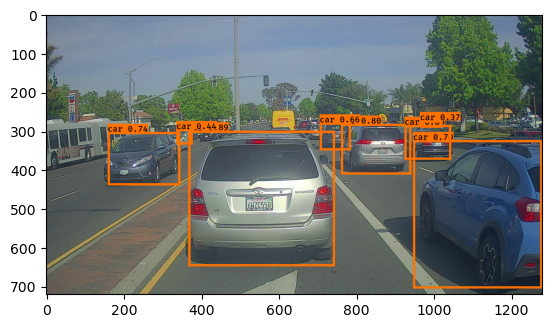

In [10]:
input_image = Image.open("images/road_image.jpg")

_, _, _, output_image = yolo_model_prediction(input_image,class_names, anchors)

imshow(output_image)

## Video Car Detection

* Extract frames from video file with OpenCV and predict car object with **`yolo_model_prediction`**

In [18]:
import cv2
import os
import glob
from PIL import Image

def getFrame(cap,sec): 
    cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000) 
    hasFrames, frame = cap.read() 
    if hasFrames: 
        pframe = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        _,_,_,frame = yolo_model_prediction(pframe,class_names, anchors)
    return hasFrames, frame 

def yolo_video_car_detection(input_file, output_file = "video/yolo_video.mp4", frame_rate = 2):

    print("Video generate start")
    
    # create OpenCV capture object for input file
    cap = cv2.VideoCapture(input_file)
    
    currentframe = 0
    sec = 0
    
    # generate frame from video and convert in to bounding box image with YOLO model prediction
    success, img_frame = getFrame(cap,sec) 
    
    if success:

        image_size = np.array(img_frame.size)
        
        # create video file
        video = cv2.VideoWriter(output_file,cv2.VideoWriter_fourcc(*'H264'), frame_rate, image_size)
        
        # write bounding box prediction frame in to video file
        video.write(cv2.cvtColor(np.array(img_frame), cv2.COLOR_RGB2BGR))

        while success: 
            sec = sec + (1.0/frame_rate) 
            sec = round(sec, 2) 
            currentframe += 1
            success, img_frame = getFrame(cap,sec) 
            if success :
                video.write(cv2.cvtColor(np.array(img_frame), cv2.COLOR_RGB2BGR))
                print('#',end=' ')

        video.release()
        print("\nVideo generate complete")
    cap.release()
    cv2.destroyAllWindows()

* Detect car object in **Car_on_Highway** video with **`yolo_video_car_detection`** 
* Generated output `yolo_video.mp4` located in video folder

In [19]:
yolo_video_car_detection("video/Car_on_Highway_night.mp4")

Video generate start
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Video generate complete


* Car detection video generated from YOLO model

In [17]:
from IPython.display import Video

Video("video/yolo_video.mp4", width=500, height=300, embed=True)

<a name='6'></a>
# References

Object detection ideas used in this notebook came from following references

- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

### Car detection dataset

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. Thanks to Brody Huval, Chih Hu and Rahul Patel for  providing this data. 